In [73]:
import json
import bz2
import regex
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from tqdm import tqdm
from scipy import sparse
from pymystem3 import Mystem
from collections import Counter
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import lsimodel
from gensim import similarities

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:38, 2036.44it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [3]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [4]:
data = pd.DataFrame(responses)

In [5]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


1. Посчитайте количество отзывов в разных городах и на разные банки

Приведем все названия городов к нижнему регистру для единобразия и почистим самые частые сокращения и ошибки.

In [7]:
data['city'] = data['city'].str.lower()

data['city'] = data['city'].str.replace('moscow', 'москва')
data['city'] = data['city'].str.replace('г. г. москва', 'г. москва')
data['city'] = data['city'].str.replace('г. г.москва', 'г. москва')
data['city'] = data['city'].str.replace('мск', 'москва')

data['city'] = data['city'].str.replace('спб', 'санкт-петербург')
data['city'] = data['city'].str.replace('с-пб', 'санкт-петербург')
data['city'] = data['city'].str.replace('питер', 'санкт-петербург')
data['city'] = data['city'].str.replace('санкт петербург', 'санкт-петербург')
data['city'] = data['city'].str.replace('санкт- петербург', 'санкт-петербург')
data['city'] = data['city'].str.replace('с-петербург', 'санкт-петербург')
data['city'] = data['city'].str.replace('санкт - петербург', 'санкт-петербург')
data['city'] = data['city'].str.replace('санк-петербург', 'санкт-петербург')
data['city'] = data['city'].str.replace('г. петербург', 'г. санкт-петербург')

data['city'] = data['city'].str.replace('ростов на дону', 'ростов-на-дону')
data['city'] = data['city'].str.replace('н.новгород', 'нижний новгород')

In [8]:
data['bank_name'] = data['bank_name'].str.replace('БИНБАНК кредитные карты', 'Бинбанк')

In [9]:
response_count = data.groupby(['city', 'bank_name']).city.agg('count').to_frame('response_count').\
                      sort_values(by='response_count', ascending=False).reset_index()

In [10]:
response_count.head(10)

,city,bank_name,response_count
0,г. москва,Сбербанк России,8344
1,г. москва,Альфа-Банк,3979
2,г. москва,Русский Стандарт,2907
3,г. москва,ВТБ 24,2761
4,г. санкт-петербург,Сбербанк России,2638
5,г. москва,Московский Кредитный Банк,2407
6,г. москва,Тинькофф Банк,2392
7,г. москва,Хоум Кредит Банк,2196
8,г. москва,Национальный Банк «Траст»,1696
9,г. москва,Райффайзенбанк,1465


2. Постройте гистограмы длин слов в символах и в словах

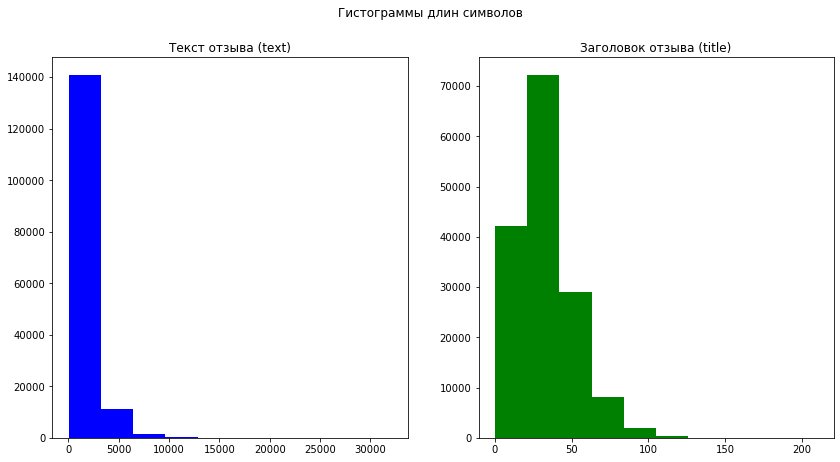

In [11]:
fig, axis = plt.subplots(ncols=2, figsize = (14,7))
text_len = data['text'].str.len()
title_len = data['title'].str.len()

axis[0].hist(text_len, color='blue')
axis[0].set_title('Текст отзыва (text)')
axis[1].hist(title_len, color='green')
axis[1].set_title('Заголовок отзыва (title)')

fig.suptitle('Гистограммы длин символов')
plt.show()

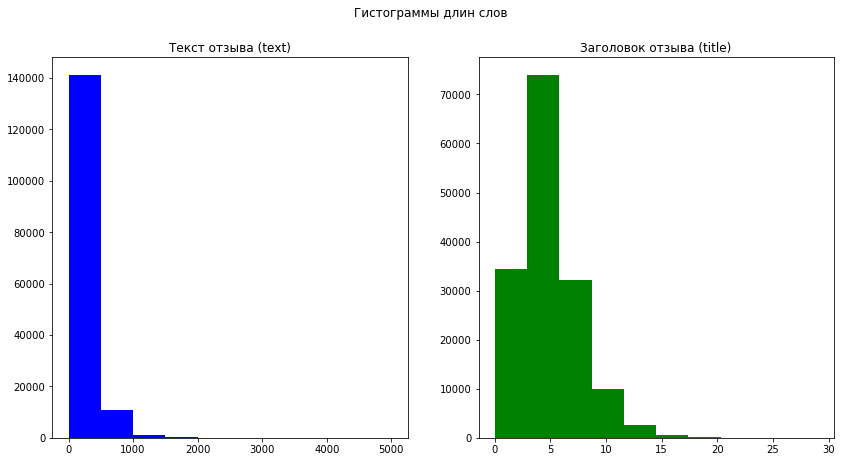

In [12]:
fig, axis = plt.subplots(ncols=2, figsize = (14,7))
text_len = data['text'].str.split().map(lambda x: len(x))
title_len = data['title'].str.split().map(lambda x: len(x))

axis[0].hist(text_len, color='blue')
axis[0].set_title('Текст отзыва (text)')
axis[1].hist(title_len, color='green')
axis[1].set_title('Заголовок отзыва (title)')

fig.suptitle('Гистограммы длин слов')
plt.show()

3. Найдите 10 самых частых: 
    * слов
    * слов без стоп-слов
    * лемм
    * существительных

In [13]:
m = Mystem()
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")

**10 самых частых слов**

In [14]:
text_words = [word for text in data['text'] for word in ru_words.findall(text.lower())]
title_words = [word for text in data['title'] for word in ru_words.findall(text.lower())]

In [15]:
cnt_text_words = Counter(text_words)
cnt_title_words = Counter(title_words)

10 самых частых слов в тексте отзыва:

In [16]:
for i in cnt_text_words.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


10 самых частых слов в заголовке отзыва:

In [17]:
for i in cnt_title_words.most_common(10):
    print(i)

('не', 21420)
('в', 18884)
('и', 12990)
('банк', 12515)
('на', 12039)
('с', 11565)
('деньги', 9265)
('банка', 9232)
('по', 8904)
('карты', 6928)


**10 самых частых слов без стоп-слов**

In [18]:
text_words_stop = [word for word in text_words if not word in mystopwords]
title_words_stop = [word for word in title_words if not word in mystopwords]

In [19]:
cnt_text_stop = Counter(text_words_stop)
cnt_title_stop = Counter(title_words_stop)

10 самых частых слов без стоп-слов в тексте отзыва:

In [20]:
for i in cnt_text_stop.most_common(10):
    print(i)

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


10 самых частых слов без стоп-слов в заголовке отзыва:

In [21]:
for i in cnt_title_stop.most_common(10):
    print(i)

('банк', 12515)
('деньги', 9265)
('банка', 9232)
('карты', 6928)
('кредит', 4131)
('обслуживание', 3841)
('банкомат', 3554)
('карту', 3243)
('сбербанк', 3033)
('сотрудников', 2782)


**10 самых частых лемм**

In [22]:
text_words_lemm = [m.lemmatize(word)[0] for word in text_words_stop]
title_words_lemm = [m.lemmatize(word)[0] for word in title_words_stop]

In [23]:
cnt_text_lemm = Counter(text_words_lemm)
cnt_title_lemm = Counter(title_words_lemm)

10 самых частых лемм в тексте отзыва:

In [24]:
for i in cnt_text_lemm.most_common(10):
    print(i)

('банк', 364704)
('карта', 334999)
('банка', 303889)
('деньги', 179734)
('день', 172952)
('мой', 163042)
('кредит', 156177)
('отделение', 144050)
('клиент', 136892)
('сотрудник', 134168)


10 самых частых лемм в заголовке отзыва:

In [25]:
for i in cnt_title_lemm.most_common(10):
    print(i)

('банк', 16632)
('карта', 16259)
('деньги', 11915)
('банка', 10365)
('кредит', 8107)
('клиент', 7411)
('банкомат', 5941)
('сбербанк', 5776)
('сотрудник', 5739)
('обслуживание', 5499)


**10 самых частых существительных**

In [26]:
m = Mystem()
text_words_s = [word for word in text_words_lemm if m.analyze(word)[0]['analysis'] and 
              'S' in m.analyze(word)[0]['analysis'][0]['gr']]
title_words_s = [word for word in title_words_lemm if m.analyze(word)[0]['analysis'] and 
               'S' in m.analyze(word)[0]['analysis'][0]['gr']]

In [27]:
cnt_text_s = Counter(text_words_s)
cnt_title_s = Counter(title_words_s)

10 самых частых существительных в тексте отзыва:

In [28]:
for i in cnt_text_s.most_common(10):
    print(i)

('банк', 364704)
('карта', 334999)
('банка', 303889)
('деньги', 179734)
('день', 172952)
('кредит', 156177)
('отделение', 144050)
('клиент', 136892)
('сотрудник', 134168)
('счет', 126894)


10 самых частых существительных в заголовке отзыва:

In [29]:
for i in cnt_title_s.most_common(10):
    print(i)

('банк', 16632)
('карта', 16259)
('деньги', 11915)
('банка', 10365)
('кредит', 8107)
('клиент', 7411)
('банкомат', 5941)
('сбербанк', 5776)
('сотрудник', 5739)
('обслуживание', 5499)


5. Постройте кривые Ципфа и Хипса

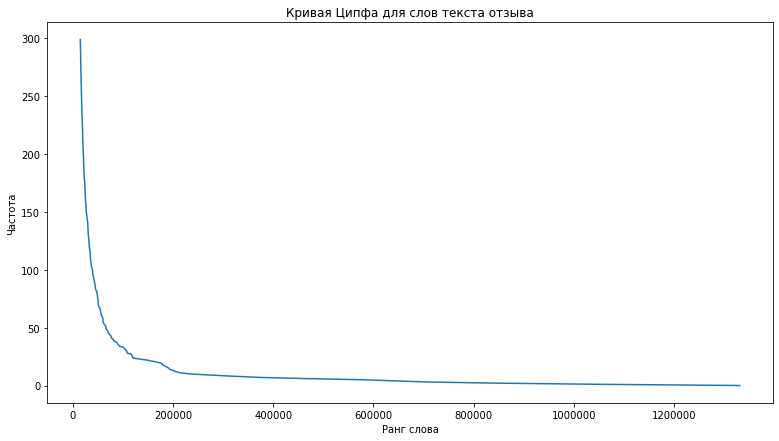

In [31]:
freqs = list(cnt_text_words.values())
freqs = sorted(freqs, reverse = True)

plt.figure(figsize = (13,7))
plt.plot(freqs[:300], range(300))
plt.title('Кривая Ципфа для слов текста отзыва')
plt.xlabel('Ранг слова')
plt.ylabel('Частота')
plt.show()

In [64]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []

for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 153499/153499 [59:57<00:00, 42.67it/s]


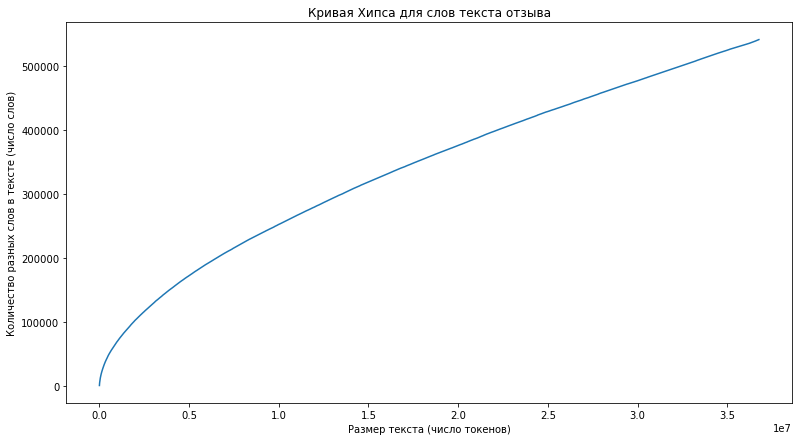

In [65]:
plt.figure(figsize = (13,7))
plt.plot(n_tokens, n_words)
plt.title('Кривая Хипса для слов текста отзыва')
plt.xlabel('Размер текста (число токенов)')
plt.ylabel('Количество разных слов в тексте (число слов)')
plt.show()

6. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [79]:
print(f'В тексте отзыва слово "сотрудник" встречается {cnt_text_lemm["сотрудник"]} раз, ' 
      f'а "клиент" - {cnt_text_lemm["клиент"]} раз')
print(f'В заголовке отзыва слово "сотрудник" встречается {cnt_title_lemm["сотрудник"]} раз, '
      f'а "клиент" - {cnt_title_lemm["клиент"]} раз')

В тексте отзыва слово "сотрудник" встречается 134168 раз, а "клиент" - 136892 раз
В заголовке отзыва слово "сотрудник" встречается 5739 раз, а "клиент" - 7411 раз


Как видно, и в тексте, и в заголовке отзыва чаще встречается слово "клиент"

In [80]:
print(f'В тексте отзыва слово "мошенничество" встречается {cnt_text_lemm["мошенничество"]} раз, ' 
      f'а "доверие" - {cnt_text_lemm["доверие"]} раз')
print(f'В заголовке отзыва слово "мошенничество" встречается {cnt_title_lemm["мошенничество"]} раз, '
      f'а "доверие" - {cnt_title_lemm["доверие"]} раз')

В тексте отзыва слово "мошенничество" встречается 3244 раз, а "доверие" - 2108 раз
В заголовке отзыва слово "мошенничество" встречается 598 раз, а "доверие" - 147 раз


7. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Для дальнейшей работы обработаем тексты отзывов и будем работать с ними.

In [14]:
def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [15]:
%%time
data['text_lemm'] = data['text'].apply(preprocess)

CPU times: user 2min 59s, sys: 4.82 s, total: 3min 4s
Wall time: 29min 18s


Возьмем 3000 положительных и 3000 отрицательных отзывов и посчитаем для них tfidf. Использовать будем обработанный текст отзывов с леммами. 

In [16]:
N = 3000

data_rating = data[data['rating_grade'] == 1].sample(n=N).append(data[data['rating_grade'] == 5].sample(n=N))
data_rating = data_rating.reset_index()

In [17]:
mask_for_1 = (data_rating['rating_grade'] == 1).tolist()
mask_for_5 = (data_rating['rating_grade'] == 5).tolist()

In [18]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)
tfidf_matrix = tfidf.fit_transform(data_rating['text_lemm'])
feature_names = tfidf.get_feature_names() 
dense = tfidf_matrix.todense()

In [19]:
text_rating_1 = dense[mask_for_1].tolist()[0]
text_rating_5 = dense[mask_for_5].tolist()[0]

In [20]:
def get_tfidf_rankings_df(text_rating):
    phrase_scores = [pair for pair in zip(range(0, len(text_rating)), text_rating) if pair[1] > 0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    
    tfidf_ranking = []
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
        tfidf_ranking.append(phrase)
    
    rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
    return rankings   

**Топ-10 ключевых слов и биграмм для отрицательных отзывов:**

In [23]:
rankings_1 = get_tfidf_rankings_df(text_rating_1)
rankings_1.head(10)

,tf-idf
0,аппарат
1,пополнять карта
2,аппарат взять
3,аппарат возникать
4,аппарат некорректный
5,банкомат отражаться
6,билет забронировать
7,вносить поэтому
8,возможный день
9,деньги возможный


**Топ-10 ключевых слов и биграмм для положительных отзывов:**

In [24]:
rankings_5 = get_tfidf_rankings_df(text_rating_5)
rankings_5.head(10)

,tf-idf
0,нужно оплачивать
1,вип
2,перевод
3,первый
4,оплачивать
5,сразу
6,абсолютно позитивный
7,ан девушка
8,арбат садовый
9,белый каменный


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [59]:
texts = [text.split() for text in data['text_lemm']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [60]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

**Тематическая модель с 30 темами:**

In [92]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 2min 16s, sys: 6.45 s, total: 2min 23s
Wall time: 1min 35s


In [93]:
lsi.show_topics(5)

[(0,
  '0.196*"карта" + 0.135*"кредит" + 0.116*"деньги" + 0.110*"заявление" + 0.108*"счет" + 0.102*"банкомат" + 0.101*"вклад" + 0.101*"отделение" + 0.097*"сумма" + 0.097*"сбербанк"'),
 (1,
  '-0.417*"вклад" + 0.347*"кредит" + -0.193*"банкомат" + 0.158*"страховка" + -0.155*"карта" + 0.147*"платеж" + 0.147*"задолженность" + 0.137*"погашение" + -0.135*"открывать" + 0.115*"звонок"'),
 (2,
  '-0.470*"вклад" + 0.293*"банкомат" + 0.228*"карта" + 0.190*"сбербанк" + -0.156*"кредит" + 0.129*"заявление" + 0.128*"операция" + 0.127*"деньги" + -0.126*"договор" + -0.122*"открывать"'),
 (3,
  '-0.260*"вклад" + -0.217*"сумма" + 0.195*"номер" + 0.187*"заявка" + -0.183*"руб" + -0.164*"платеж" + -0.160*"погашение" + -0.150*"договор" + 0.146*"звонок" + -0.145*"процент"'),
 (4,
  '0.321*"вклад" + 0.273*"номер" + -0.254*"карта" + -0.215*"страховка" + 0.195*"звонок" + -0.192*"заявка" + 0.141*"телефон" + -0.141*"кредит" + 0.141*"ваш" + -0.123*"лимит"')]

1. Первая тема (под номером 0 выше) содержит в себе все типичные слова, какие могут быть в отзыве про банк: "карта, кредит, деньги, заявление, счет, банкомат, вклад, отделение, сумма, сбербанк". Тут же присутствует название банка Сбербанк, так как больше всего отзывов именно про этот банк. 
2. Вторая тема (под номером 1 выше) также содержит в себе типичные слова про банк, но тут речь больше идет про внесение каких-то платежей, погашение задолжностей исходя из слов "страховка, платеж, задолженность, погашение". Сюда же могут относится, например, отзывы про открытие карт (слова "открывать, карта") и жалобы на очереди (слово "очередь"). 
3. Последняя тема (под номером 4 выше) скорее всего содержит отзывы, касающиеся звонков по телефону, так как в ней есть слова "номер, звонок, телефон" и плюс слова, касающиеся банковских дел - "вклад, карта, страховка, кредит, лимит". <br>

Во многих темах встречается название банка "Сбербанк", так как отзывов в данном датасете больше всего именно про него. Пример темы с банком "Сбербанк":

In [94]:
lsi.show_topic(0)

[('карта', 0.19617875269654156),
 ('кредит', 0.13471726473733536),
 ('деньги', 0.11620271052192019),
 ('заявление', 0.10991615808041313),
 ('счет', 0.10782441114669254),
 ('банкомат', 0.10221833740956097),
 ('вклад', 0.1014884193351829),
 ('отделение', 0.10084380298783638),
 ('сумма', 0.09699525717604734),
 ('сбербанк', 0.09679029578192633)]

Здесь может быть описана практически любая проблема, так как присутствуют самые типичные банковские слова.

Пример темы с банком "Альфа-Банк" (второй по популярности банк в данном датасете): 

In [103]:
lsi.show_topic(13)

[('альфа', -0.3926218857601513),
 ('претензия', -0.24386397153980638),
 ('кошелек', 0.20999777774423584),
 ('услуга', -0.20370614769013626),
 ('терминал', 0.1983143064328286),
 ('погашение', -0.18807550365820128),
 ('смс', -0.17100231279819111),
 ('киви', 0.16801417205140975),
 ('досрочный', -0.1673480510710219),
 ('подключать', -0.1631099403447694)]

Здесь может идти речь про электронные кошельки и подключение каких-то услуг ("услуга, кошелек, киви, подключать, смс"). Скорее всего тема содержит отрицательные отзывы, так как есть слово "претензия". 

Еще один отзыв с банком "Альфа-Банк":

In [120]:
lsi.show_topic(14)

[('руб', 0.28126936887997245),
 ('альфа', -0.24950055940238802),
 ('комиссия', 0.24451551949233713),
 ('заявка', 0.21187767944140345),
 ('очередь', 0.18433159285410539),
 ('касса', 0.15280422033602056),
 ('кошелек', -0.14874977725763103),
 ('деньги', -0.14484685402800215),
 ('терминал', 0.11969710602369368),
 ('кассир', 0.11875483826141985)]

Здесь есть сочетание слов "касса, кассир, очередь, деньги, терминал, комиссия, руб". Могут быть отзывы про работу с кассами.

**Тематическая модель с 10 темами:**

In [63]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 2min 13s, sys: 7.71 s, total: 2min 20s
Wall time: 1min 35s


In [64]:
lsi.show_topics(5)

[(0,
  '0.196*"карта" + 0.135*"кредит" + 0.116*"деньги" + 0.110*"заявление" + 0.108*"счет" + 0.102*"вклад" + 0.102*"банкомат" + 0.101*"отделение" + 0.097*"сбербанк" + 0.097*"сумма"'),
 (1,
  '-0.464*"вклад" + 0.334*"кредит" + 0.157*"платеж" + -0.156*"банкомат" + 0.150*"страховка" + 0.149*"задолженность" + -0.147*"открывать" + 0.136*"погашение" + -0.129*"карта" + -0.123*"очередь"'),
 (2,
  '-0.424*"вклад" + 0.289*"банкомат" + 0.242*"карта" + 0.211*"сбербанк" + -0.195*"кредит" + -0.139*"договор" + 0.138*"операция" + 0.132*"деньги" + 0.125*"заявление" + 0.124*"средство"'),
 (3,
  '-0.272*"вклад" + -0.214*"сумма" + 0.207*"заявка" + 0.186*"номер" + -0.182*"руб" + -0.161*"платеж" + -0.153*"погашение" + -0.150*"договор" + -0.146*"рубль" + -0.145*"процент"'),
 (4,
  '-0.448*"карта" + 0.309*"банкомат" + -0.197*"лимит" + -0.187*"кредитный" + 0.151*"номер" + 0.131*"деньги" + 0.130*"терминал" + 0.123*"купюра" + 0.116*"звонок" + -0.115*"комиссия"')]

**Тематическая модель с 50 темами:**

In [65]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=50)

CPU times: user 2min 36s, sys: 7.41 s, total: 2min 44s
Wall time: 1min 41s


In [66]:
lsi.show_topics(5)

[(0,
  '0.196*"карта" + 0.135*"кредит" + 0.116*"деньги" + 0.110*"заявление" + 0.108*"счет" + 0.102*"банкомат" + 0.102*"вклад" + 0.101*"отделение" + 0.097*"сумма" + 0.097*"сбербанк"'),
 (1,
  '-0.410*"вклад" + 0.350*"кредит" + -0.197*"банкомат" + 0.159*"страховка" + -0.157*"карта" + 0.146*"платеж" + 0.146*"задолженность" + 0.136*"погашение" + -0.134*"открывать" + 0.115*"звонок"'),
 (2,
  '-0.475*"вклад" + 0.290*"банкомат" + 0.225*"карта" + 0.189*"сбербанк" + -0.152*"кредит" + 0.129*"заявление" + 0.127*"операция" + 0.125*"деньги" + -0.125*"договор" + -0.124*"открывать"'),
 (3,
  '-0.253*"вклад" + -0.217*"сумма" + 0.201*"номер" + 0.187*"заявка" + -0.183*"руб" + -0.164*"платеж" + -0.160*"погашение" + -0.150*"договор" + 0.150*"звонок" + -0.145*"процент"'),
 (4,
  '0.326*"вклад" + 0.273*"номер" + -0.246*"карта" + -0.215*"страховка" + -0.194*"заявка" + 0.192*"звонок" + 0.144*"ваш" + 0.141*"телефон" + -0.141*"кредит" + -0.121*"лимит"')]

В целом, все тематические модели выше независимо от количества тем выделяют примерно одинаковые слова и довольно похоже их группируют (по крайней мере исходя из первых 5-топ тем).

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
    * 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
    * 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [25]:
data.shape

(153499, 11)

In [26]:
N1 = 7000
N2 = 7000

temp = data[data['rating_grade'] == 1].sample(n=N1).append(data[data['rating_grade'] == 5].sample(n=N2))
temp_X = temp['text_lemm']
temp_Y = temp['rating_grade']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(temp_X, temp_Y, test_size=0.3, random_state=15, shuffle=True)

In [28]:
X_train.shape, X_test.shape

((9800,), (4200,))

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 

**Использование символьных n-грамм**

In [31]:
clf = Pipeline([
 ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
 ('clf', RandomForestClassifier(random_state=16)),
])

clf = clf.fit(X_train, y_train)

In [32]:
train_accuracy_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
test_accuracy_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1))

In [33]:
train_f1_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
test_f1_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='f1', n_jobs=-1))

In [34]:
print(f'Train accuracy: {train_accuracy_score:.3f}, Train F-measure: {train_f1_score:.3f}\n'
      f'Test accuracy: {test_accuracy_score:.3f}, Test F-measure: {test_f1_score:.3f}')

Train accuracy: 0.916, Train F-measure: 0.917
Test accuracy: 0.903, Test F-measure: 0.904


**Использование униграмм**

In [35]:
clf = Pipeline([
 ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,1))),
 ('clf', RandomForestClassifier(random_state=16)),
])

clf = clf.fit(X_train, y_train)

In [36]:
train_accuracy_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
test_accuracy_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1))

In [37]:
train_f1_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
test_f1_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='f1', n_jobs=-1))

In [38]:
print(f'Train accuracy: {train_accuracy_score:.3f}, Train F-measure: {train_f1_score:.3f}\n'
      f'Test accuracy: {test_accuracy_score:.3f}, Test F-measure: {test_f1_score:.3f}')

Train accuracy: 0.921, Train F-measure: 0.922
Test accuracy: 0.911, Test F-measure: 0.912


**Использование биграмм**

In [39]:
clf = Pipeline([
 ('vect', CountVectorizer(analyzer = 'word', ngram_range=(2,2))),
 ('clf', RandomForestClassifier(random_state=16)),
])

clf = clf.fit(X_train, y_train)

In [40]:
train_accuracy_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
test_accuracy_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1))

In [41]:
train_f1_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
test_f1_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='f1', n_jobs=-1))

In [42]:
print(f'Train accuracy: {train_accuracy_score:.3f}, Train F-measure: {train_f1_score:.3f}\n'
      f'Test accuracy: {test_accuracy_score:.3f}, Test F-measure: {test_f1_score:.3f}')

Train accuracy: 0.861, Train F-measure: 0.855
Test accuracy: 0.843, Test F-measure: 0.832


**Использование триграмм**

In [43]:
clf = Pipeline([
 ('vect', CountVectorizer(analyzer = 'word', ngram_range=(3,3))),
 ('clf', RandomForestClassifier(random_state=16)),
])

clf = clf.fit(X_train, y_train)

In [44]:
train_accuracy_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
test_accuracy_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1))

In [45]:
train_f1_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
test_f1_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='f1', n_jobs=-1))

In [46]:
print(f'Train accuracy: {train_accuracy_score:.3f}, Train F-measure: {train_f1_score:.3f}\n'
      f'Test accuracy: {test_accuracy_score:.3f}, Test F-measure: {test_f1_score:.3f}')

Train accuracy: 0.674, Train F-measure: 0.553
Test accuracy: 0.685, Test F-measure: 0.587


**Использование униграмм, биграмм и триграмм вместе**

In [47]:
clf = Pipeline([
 ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,3))),
 ('clf', RandomForestClassifier(random_state=16)),
])

clf = clf.fit(X_train, y_train)

In [48]:
train_accuracy_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
test_accuracy_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1))

In [49]:
train_f1_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
test_f1_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='f1', n_jobs=-1))

In [50]:
print(f'Train accuracy: {train_accuracy_score:.3f}, Train F-measure: {train_f1_score:.3f}\n'
      f'Test accuracy: {test_accuracy_score:.3f}, Test F-measure: {test_f1_score:.3f}')

Train accuracy: 0.906, Train F-measure: 0.908
Test accuracy: 0.897, Test F-measure: 0.898


Самый лучший результат был достигнут при использовании символьных n-грамм и униграмм.

3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
    * 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
    * 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

**Tfidf + TruncatedSVD (LSI)**

In [51]:
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,1))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(random_state = 11, n_components = 30)), 
    ('clf', RandomForestClassifier(random_state = 16))
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [52]:
train_accuracy_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
test_accuracy_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1))

In [53]:
train_f1_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
test_f1_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='f1', n_jobs=-1))

In [54]:
print(f'Train accuracy: {train_accuracy_score:.3f}, Train F-measure: {train_f1_score:.3f}\n'
      f'Test accuracy: {test_accuracy_score:.3f}, Test F-measure: {test_f1_score:.3f}')

Train accuracy: 0.884, Train F-measure: 0.887
Test accuracy: 0.866, Test F-measure: 0.867


**LDA**

In [55]:
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,1))), 
    ('lda', LatentDirichletAllocation(random_state = 7, n_components = 150)),
    ('clf', RandomForestClassifier(random_state = 16))
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [56]:
train_accuracy_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1))
test_accuracy_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1))

In [57]:
train_f1_score = np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1))
test_f1_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='f1', n_jobs=-1))

In [58]:
print(f'Train accuracy: {train_accuracy_score:.3f}, Train F-measure: {train_f1_score:.3f}\n'
      f'Test accuracy: {test_accuracy_score:.3f}, Test F-measure: {test_f1_score:.3f}')

Train accuracy: 0.875, Train F-measure: 0.871
Test accuracy: 0.844, Test F-measure: 0.838


Как видно, при использовании tf-idf преобразования + SVD, качество классификации немного выше, чем при LDA. Но в любом случае качество стало хуже, чем при простом использовании униграмм. 